## Q3 ~ Amy

In [1]:

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import json
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime, timedelta
# store login data in login.py
%run login.py

loginquery = f"""
mutation {{
  logIn(
      email:\"{login}\",
      password:\"{pwd}\") {{
    jwt {{
      token
      exp
    }}
  }}
}}
"""
import requests
url = 'https://api.numina.co/graphql'

mylogin = requests.post(url, json={'query': loginquery})
token = mylogin.json()['data']['logIn']['jwt']['token']
expdate = mylogin.json()['data']['logIn']['jwt']['exp']

In [2]:
query2 = """
query {
  feedCountMetrics(
    serialnos:["SWLSANDBOX3", "SWLSANDBOX1", "SWLSANDBOX2"],
    startTime:"2018-01-01T00:00:00",
    endTime:"2019-12-31T00:00:00",
    objClasses:["pedestrian"],
    timezone:"America/New_York",
    interval:"24h") {
    edges {
      node {
        serialno
        result
        objClass
        time
      }
    }
  }
}
"""

peds = requests.post(url, json={'query': query2}, headers = {'Authorization':token})


l = peds.json()['data']['feedCountMetrics']['edges']
query1 = """
query {
  feedCountMetrics(
    serialnos:["SWLSANDBOX3", "SWLSANDBOX1", "SWLSANDBOX2"],
    startTime:"2018-01-01T00:00:00",
    endTime:"2019-12-31T00:00:00",
    objClasses:["bicycle"],
    timezone:"America/New_York",
    interval:"24h") {
    edges {
      node {
        serialno
        result
        objClass
        time
      }
    }
  }
}
"""
bikes = requests.post(url, json={'query': query1}, headers = {'Authorization':token})

b = bikes.json()['data']['feedCountMetrics']['edges']

query3 = """
query {
  feedCountMetrics(
    serialnos:["SWLSANDBOX3", "SWLSANDBOX1", "SWLSANDBOX2"],
    startTime:"2018-01-01T00:00:00",
    endTime:"2019-12-31T00:00:00",
    objClasses:["car"],
    timezone:"America/New_York",
    interval:"24h") {
    edges {
      node {
        serialno
        result
        objClass
        time
      }
    }
  }
}
"""
cars = requests.post(url, json={'query': query3}, headers = {'Authorization':token})

c = cars.json()['data']['feedCountMetrics']['edges']

In [3]:
query0 = """
query {
  devices {
    count
    edges {
      node {
        rawId
        name
        serialno
      }
    }
  }
}
"""
s = requests.post(url, json={'query': query0}, headers = {'Authorization':token})
s.json()['data']

{'devices': {'count': 3,
  'edges': [{'node': {'name': 'Streetscape - Sandbox',
     'rawId': '1b41b3eb5c254ea188c5bba172a89f76',
     'serialno': 'SWLSANDBOX1'}},
   {'node': {'name': 'Outside - Sandbox',
     'rawId': '29b315c428c54c77833d10822b429ded',
     'serialno': 'SWLSANDBOX3'}},
   {'node': {'name': 'Under Raincoat - Sandbox',
     'rawId': 'b0e5945bb2b14ad5977b138cd534c42e',
     'serialno': 'SWLSANDBOX2'}}]}}

In [4]:
def f(x):
    
    sensor = x
    display(sensor)
    return sensor

sensor = interactive(f, x=widgets.Dropdown(options=["SWLSANDBOX1", "SWLSANDBOX2", "SWLSANDBOX3"], value = "SWLSANDBOX1", disabled = False))
display(sensor)
#outside sandbox

interactive(children=(Dropdown(description='x', options=('SWLSANDBOX1', 'SWLSANDBOX2', 'SWLSANDBOX3'), value='…

In [5]:
from datetime import datetime
df = pd.DataFrame(columns = ['Date', 'Number of Pedestrians', "Day of Week", 'Bikes', 'Cars'])


for node in l:
    if node['node']['serialno'] == sensor.result:
        date = datetime.strptime(node['node']['time'][:10], '%Y-%m-%d')
        df = df.append({'Date': date, 'Number of Pedestrians': node['node']['result'], "Day of Week" : date.strftime('%A')}, ignore_index=True)
df.set_index('Date', inplace=True)

for node in b:
    if node['node']['serialno'] == sensor.result:
        date = datetime.strptime(node['node']['time'][:10], '%Y-%m-%d')
        df['Bikes'][date] = node['node']['result']

for node in c:
    if node['node']['serialno'] == sensor.result:
        date = datetime.strptime(node['node']['time'][:10], '%Y-%m-%d')
        df['Cars'][date] = node['node']['result']

    
df['Total'] = df['Number of Pedestrians'] + df['Cars'] + df['Bikes']
df[['Total', 'Number of Pedestrians', 'Bikes', 'Cars']] = df[['Total', 'Number of Pedestrians', 'Bikes', 'Cars']].astype('int32')


testing_df = df.drop(df[df.Total == 0].index)


df.tail()

/Users/Amy0127/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Amy0127/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Number of Pedestrians,Day of Week,Bikes,Cars,Total
Date,,,,,
2019-12-26,1,Thursday,0,0,1
2019-12-27,268,Friday,0,0,268
2019-12-28,4763,Saturday,0,0,4763
2019-12-29,158,Sunday,0,0,158
2019-12-30,1175,Monday,0,0,1175


In [6]:
import scipy
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)


import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(colorscale='plotly', world_readable=True)

# Extra options
pd.options.display.max_rows = 30
pd.options.display.max_columns = 25

# Show all code cells outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
def print_articles_published(start_date, end_date):
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    stat_df = df.loc[(df.index >= start_date) & (df.index <= end_date)].copy()
    total_ppl = stat_df['Number of Pedestrians'].sum()
    
    num= len(stat_df)
    print(f'There were {num} pedestrians between {start_date.date()} and {end_date.date()}.')
    
_ = interact(print_articles_published,
             start_date=widgets.DatePicker(value=pd.to_datetime('2019-01-01')),
             end_date=widgets.DatePicker(value=pd.to_datetime('2020-01-01')))

interactive(children=(DatePicker(value=Timestamp('2019-01-01 00:00:00'), description='start_date'), DatePicker…

In [19]:

def plot_up_to(column, start_date, end_date):
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    
    plot_df = df.loc[(df.index >= start_date) & (df.index <= end_date)].copy()
    plot_df[column].iplot(mode='lines',
                                   xTitle='Date',
                                   yTitle=column, 
                                  title=f'{column.title()}  between {start_date.date()} and {end_date.date()}.')
    
_ = interact(plot_up_to, column=widgets.Dropdown(options=list(df.select_dtypes('number').columns), value = 'Number of Pedestrians'), 
             start_date=widgets.DatePicker(value=pd.to_datetime('2019-01-01')),
             end_date=widgets.DatePicker(value=pd.to_datetime('2020-01-01')))

interactive(children=(Dropdown(description='column', options=('Number of Pedestrians', 'Bikes', 'Cars', 'Total…

In [8]:
def remove_outliers(df):
    
    q1 = testing_df['Total'].quantile(0.10)
    q3 = testing_df['Total'].quantile(0.90)

    interquartile_range = q3 - q1

    df = df[~((df['Total'] < (q1)) \
             |(df['Total'] > (q3)))]
    return df
no_outliers = remove_outliers(df)


In [9]:
import seaborn as sns
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
def plot_week_days(column, start_date, end_date):
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    
    plot_df = no_outliers.loc[(no_outliers.index >= start_date) & (no_outliers.index <= end_date)].copy()
    sns.barplot(x="Day of Week", y=column, data= plot_df.groupby(['Day of Week'])[column].mean().reset_index(), order = order)
    
_ = interact(plot_week_days, column=widgets.Dropdown(options=list(no_outliers.select_dtypes('number').columns)), 
             start_date=widgets.DatePicker(value=pd.to_datetime('2019-01-01')),
             end_date=widgets.DatePicker(value=pd.to_datetime('2020-01-01')))



interactive(children=(Dropdown(description='column', options=('Number of Pedestrians', 'Bikes', 'Cars', 'Total…

In [10]:
# count 500 hrs when there is a pedestrian passing by
query2 = """
query {
  feedCountMetrics(
    serialnos:["SWLSANDBOX3", "SWLSANDBOX1", "SWLSANDBOX2"],
    startTime:"2018-01-01T00:00:00",
    endTime:"2019-12-31T00:00:00",
    objClasses:["pedestrian"],
    timezone:"America/New_York",
    interval:"1h") {
    edges {
      node {
        serialno
        result
        objClass
        time
      }
    }
  }
}
"""

peds = requests.post(url, json={'query': query2}, headers = {'Authorization':token})


l = peds.json()['data']['feedCountMetrics']['edges']
query1 = """
query {
  feedCountMetrics(
    serialnos:["SWLSANDBOX3", "SWLSANDBOX1", "SWLSANDBOX2"],
    startTime:"2018-01-01T00:00:00",
    endTime:"2019-12-31T00:00:00",
    objClasses:["bicycle"],
    timezone:"America/New_York",
    interval:"1h") {
    edges {
      node {
        serialno
        result
        objClass
        time
      }
    }
  }
}
"""
bikes = requests.post(url, json={'query': query1}, headers = {'Authorization':token})

b = bikes.json()['data']['feedCountMetrics']['edges']

query3 = """
query {
  feedCountMetrics(
    serialnos:["SWLSANDBOX3", "SWLSANDBOX1", "SWLSANDBOX2"],
    startTime:"2018-01-01T00:00:00",
    endTime:"2019-12-31T00:00:00",
    objClasses:["car"],
    timezone:"America/New_York",
    interval:"1h") {
    edges {
      node {
        serialno
        result
        objClass
        time
      }
    }
  }
}
"""
cars = requests.post(url, json={'query': query3}, headers = {'Authorization':token})

c = cars.json()['data']['feedCountMetrics']['edges']

In [11]:
from datetime import datetime
hourly = pd.DataFrame(columns = ['Date', 'Number of Pedestrians', "Day of Week", 'Bikes', 'Cars'])


for node in l:
    if node['node']['serialno'] == sensor.result:
        date = node['node']['time'][:10]
        hr = node['node']['time'][11:16]
        time = date +' '+ hr
        date = datetime.strptime(time, '%Y-%m-%d %H:%M')
        hourly = hourly.append({'Date': date, 'Number of Pedestrians': node['node']['result'], "Day of Week" : date.strftime('%A')}, ignore_index=True)
hourly.set_index('Date', inplace=True)

for node in b:
    if node['node']['serialno'] == sensor.result:
        date = node['node']['time'][:10]
        hr = node['node']['time'][11:16]
        time = date +' '+ hr
        date = datetime.strptime(time, '%Y-%m-%d %H:%M')
        hourly['Bikes'][date] = node['node']['result']

for node in c:
    if node['node']['serialno'] == sensor.result:
        date = node['node']['time'][:10]
        hr = node['node']['time'][11:16]
        time = date +' '+ hr
        date = datetime.strptime(time, '%Y-%m-%d %H:%M')
        hourly['Cars'][date] = node['node']['result']

    
hourly['Total'] = hourly['Number of Pedestrians'] + hourly['Cars'] + hourly['Bikes']
hourly[['Total', 'Number of Pedestrians', 'Bikes', 'Cars']] = hourly[['Total', 'Number of Pedestrians', 'Bikes', 'Cars']].astype('int32')
hourly['Hour'] = hourly.index.time



In [21]:

testing = hourly.drop(hourly[hourly.Total == 0].index)
testing.describe()

,Number of Pedestrians,Bikes,Cars,Total
count,3608.000000,3608.0,3608.0,3608.000000
mean,103.195676,0.0,0.0,103.195676
std,194.200132,0.0,0.0,194.200132
min,1.000000,0.0,0.0,1.000000
25%,8.000000,0.0,0.0,8.000000
50%,30.000000,0.0,0.0,30.000000
75%,111.000000,0.0,0.0,111.000000
max,2432.000000,0.0,0.0,2432.000000


In [13]:
dates = []
def get_maintenance(df):
    
    count = 0
    for index, row in df.iterrows():
        if row['Total'] > 0 & row['Total'] < 1000:
            count += 1
        if row['Total'] >= 1000:
            count += row['Total']
        if count >= 500:
            dates.append(index)
            count = 0

get_maintenance(hourly)

In [20]:
import plotly.graph_objects as go
from datetime import datetime, timedelta

def plot_up_to(column, start_date, end_date):
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    
    plot_df = df.loc[(df.index >= start_date) & (df.index <= end_date)].copy()
    fig = go.Figure()

    # Add scatter trace for line
    fig.add_trace(go.Scatter(
        x=plot_df.index,
        y=plot_df.Total,
        mode="lines",
        name="Total Objects"
    ))
    shapes = list()
    for date in dates:
            shapes.append(
                dict(
                type="rect",
                # x-reference is assigned to the x-values
                xref="x",
                # y-reference is assigned to the plot paper [0,1]
                yref="paper",
                x0=date,
                y0=0,
                x1= date + timedelta(hours=9),
                y1=1,
                fillcolor="Red",
                opacity=0.5,
                layer="above",
                line_width=0,
            ))   
    # Add shape regions
    fig.update_layout(
        shapes = shapes,
    )
    iplot(fig)
    
_ = interact(plot_up_to, column= 'Total', 
             start_date=widgets.DatePicker(value=pd.to_datetime('2019-01-01')),
             end_date=widgets.DatePicker(value=pd.to_datetime('2020-01-01')))

interactive(children=(Text(value='Total', description='column'), DatePicker(value=Timestamp('2019-01-01 00:00:…

In [15]:
hour_df = pd.DataFrame()
hour_df['Total Objects'] = hourly.groupby('Hour')['Total'].mean()

In [16]:
import plotly.express as px

def set_up():
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=hour_df.index,
        y=hour_df['Total Objects'],
        mode="lines",
        name="Total Objects"
    ))

    # Add shape regions
    fig.update_layout(
        shapes = [dict(
                type="rect",
                # x-reference is assigned to the x-values
                xref="x",
                # y-reference is assigned to the plot paper [0,1]
                yref="paper",
                x0='09:00:00',
                y0=0,
                x1= '19:00:00',
                y1=1,
                fillcolor="Red",
                opacity=0.2,

            )]
    )
    iplot(fig)
    
set_up()

In [17]:
import numpy as np
df['Quarter'] = df.index.month
df['Quarter'] = np.ceil(df['Quarter']/3).astype(int)
no_outliers['Quarter']= df['Quarter']

Text(0.5, 1.0, 'Jan. - Mar.')

(0, 2000)

Text(0, 0.5, 'Average Daily Trips')

Text(0.5, 1.0, 'Apr. - Jun.')

(0, 2000)

Text(0, 0.5, 'Average Daily Trips')

Text(0.5, 1.0, 'Jul. - Sept.')

(0, 2000)

Text(0, 0.5, 'Average Daily Trips')

Text(0.5, 1.0, 'Oct. - Dec.')

(0, 2000)

Text(0, 0.5, 'Average Daily Trips')

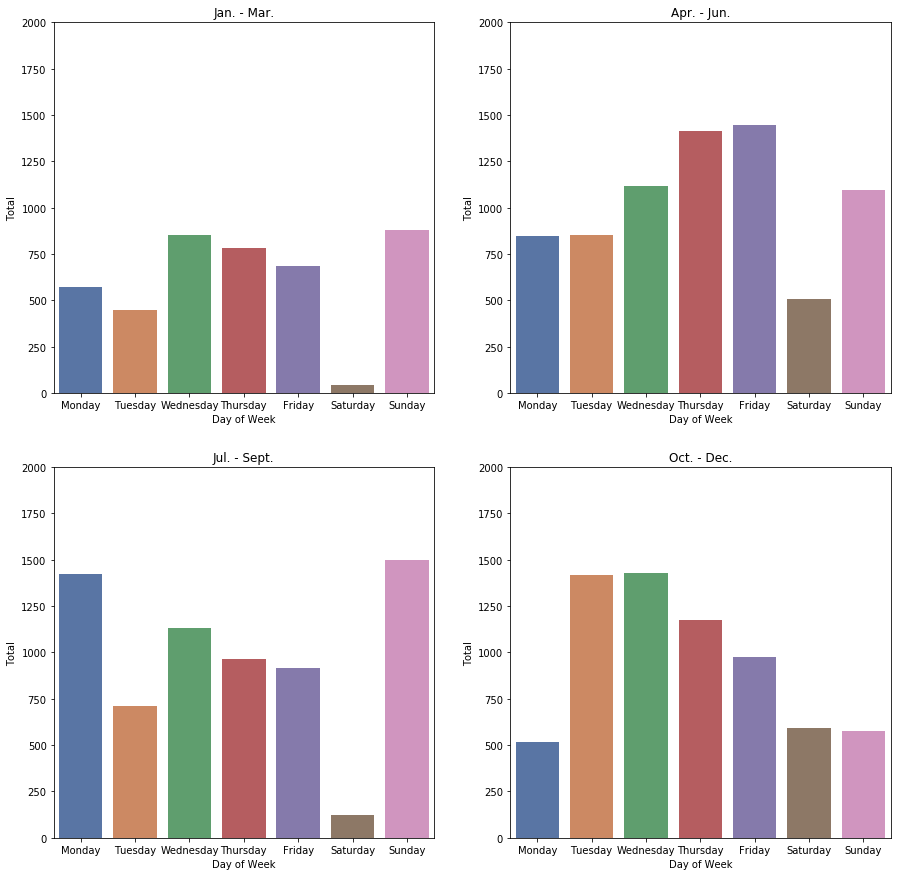

In [18]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Flatten the 2D axes array for ease of looping
axes = np.array(axes).flatten()

# Prepare the month description titles for each quarter
quarter_names = ['Jan. - Mar.', 'Apr. - Jun.', 'Jul. - Sept.', 'Oct. - Dec.']
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for q, ax in zip(sorted(no_outliers['Quarter'].unique()), axes):
    ax.set_title(quarter_names[(q-1)])
    
    # Set the y-axis range for consistency across the four graphs
    ax.set_ylim(0, 2000)
    ax.set_ylabel('Average Daily Trips')
    
    sns.barplot(
        x='Day of Week', 
        y='Total', 
        data=no_outliers[no_outliers['Quarter']==q].groupby('Day of Week')['Total'].mean().reset_index(),
        ax=ax,
        order = order,
        palette="deep"
    )